In [1]:
%tensorflow_version 1.x
!pip install librosa

TensorFlow 1.x selected.


In [2]:
!git clone https://github.com/saisriteja/sashank_Teja_paperwork.git

Cloning into 'sashank_Teja_paperwork'...
remote: Enumerating objects: 2951, done.
remote: Total 2951 (delta 0), reused 0 (delta 0), pack-reused 2951
Receiving objects: 100% (2951/2951), 391.00 MiB | 15.16 MiB/s, done.
Resolving deltas: 100% (43/43), done.
Checking out files: 100% (2842/2842), done.


In [3]:
from sashank_Teja_paperwork.codes.arxiv_model import resnet_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras import backend as K
from keras.metrics import categorical_accuracy


model = resnet_model()


Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)

path = '/content/sashank_Teja_paperwork/Teja_work/teja_data/spectrogram_data'

train_generator = train_datagen.flow_from_directory(path,
                                                      target_size=(256,256*4),
                                                      batch_size=16,
                                                      class_mode="categorical",color_mode = 'grayscale',shuffle = True,subset='training')
validation_generator = train_datagen.flow_from_directory(path,
                                                      target_size=(256,256*4),
                                                      batch_size=16,
                                                      class_mode="categorical",color_mode = 'grayscale',shuffle = True,subset='validation')

Found 714 images belonging to 2 classes.
Found 177 images belonging to 2 classes.


In [5]:
import keras
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=5, monitor="val_categorical_accuracy",min_delta=0.001,verbose = 1),
    keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5',verbose = 1,save_best_only=True)
]

In [6]:
model.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=[categorical_accuracy])
history = model.fit_generator(train_generator,
                              steps_per_epoch=50,
                              epochs=30,
                              validation_data=validation_generator,
                              validation_steps=10,
                              # class_weight=class_weights,
                              callbacks = my_callbacks)


Epoch 1/30
50/50 [==============================] - 103s 2s/step - loss: 0.6552 - categorical_accuracy: 0.6461 - val_loss: 0.6419 - val_categorical_accuracy: 0.6562

Epoch 00001: val_loss improved from inf to 0.64193, saving model to model.01-0.64.h5
Epoch 2/30
50/50 [==============================] - 89s 2s/step - loss: 0.5127 - categorical_accuracy: 0.7280 - val_loss: 0.6183 - val_categorical_accuracy: 0.6345

Epoch 00002: val_loss improved from 0.64193 to 0.61830, saving model to model.02-0.62.h5
Epoch 3/30
50/50 [==============================] - 88s 2s/step - loss: 0.2025 - categorical_accuracy: 0.9213 - val_loss: 0.9228 - val_categorical_accuracy: 0.6276

Epoch 00003: val_loss did not improve from 0.61830
Epoch 4/30
50/50 [==============================] - 88s 2s/step - loss: 0.0572 - categorical_accuracy: 0.9786 - val_loss: 0.6971 - val_categorical_accuracy: 0.5724

Epoch 00004: val_loss did not improve from 0.61830
Epoch 5/30
50/50 [==============================] - 89s 2s/ste

In [33]:
model.load_weights('/content/model.02-0.62.h5')
predictions = model.predict_generator(validation_generator)

import numpy as np

from sklearn import metrics
val_preds = np.argmax(predictions, axis=-1)
val_trues = validation_generator.classes
labels = validation_generator.class_indices.keys()

# print(labels,val_trues,val_preds)
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(val_trues, val_preds)
cnf_matrix

array([[  9,  51],
       [ 12, 105]])

In [34]:
from keras.models import Model
import copy
import warnings
warnings.filterwarnings('ignore')
import cv2
import keras
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, Input
from keras.layers import Conv2D, Activation, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.resnet50 import preprocess_input, ResNet50
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [35]:
%matplotlib inline
label_to_class = {
    'filler': 0,
    'nonfiller':1
}
class_to_label = {v: k for k, v in label_to_class.items()}

In [36]:
#filler
from glob import glob
import cv2

def read_img(file_path):
    img_spec = cv2.imread(file_path,0)
    img_spec = cv2.resize(img_spec,(256*4,256))
    img_spec=np.expand_dims(img_spec,axis = -1)
    return img_spec

In [48]:

def superimpose(img, cam):
    """superimpose original image and cam heatmap"""
    
    heatmap = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap * .5 + img * .5
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return img, heatmap, superimposed_img

def plot(model, cam_func, img, cls_true):
    
  i = img  
  img = img/255.0
  x = np.expand_dims(img, axis=0)
  # x = preprocess_input(copy.deepcopy(x))



    # cam / superimpose
  cls_pred, cam = cam_func(model=model, x=x, layer_name=model.layers[-9].name)
  img, heatmap, superimposed_img = superimpose(i, cam)

  fig, axs = plt.subplots(ncols=3, figsize=(18,3))

  axs[0].imshow(i.squeeze())
  axs[0].set_title('original image')
  axs[0].axis('off')

  axs[1].imshow(heatmap)
  axs[1].set_title('heatmap')
  axs[1].axis('off')

  axs[2].imshow(superimposed_img)
  axs[2].set_title('superimposed image')
  axs[2].axis('off')

  plt.suptitle('True label: ' + class_to_label[np.argmax(cls_true)] + ' / Predicted label : ' + class_to_label[cls_pred])
  plt.tight_layout()
  plt.show()

def grad_cam(model, x, layer_name):
    """Grad-CAM function"""
    
    cls = np.argmax(model.predict(x))
    
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    # Get outputs and grads
    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([x])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    
    weights = np.mean(grads_val, axis=(0, 1)) # Passing through GlobalAveragePooling

    cam = np.dot(output, weights) # multiply
    cam = np.maximum(cam, 0)      # Passing through ReLU
    cam /= np.max(cam)            # scale 0 to 1.0

    return cls, cam

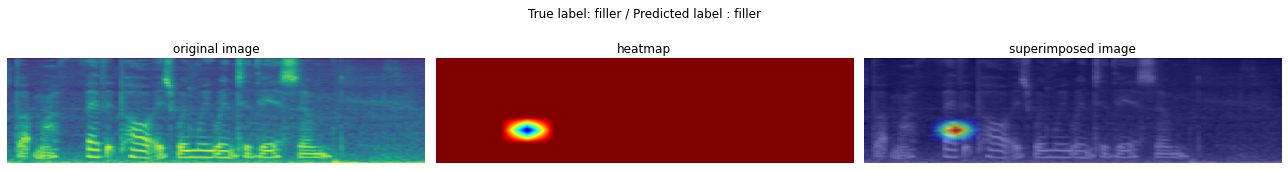

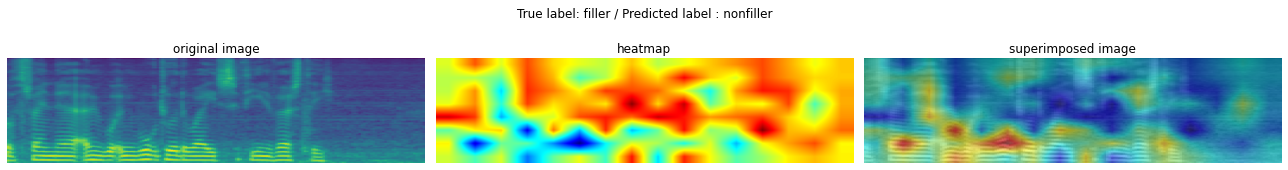

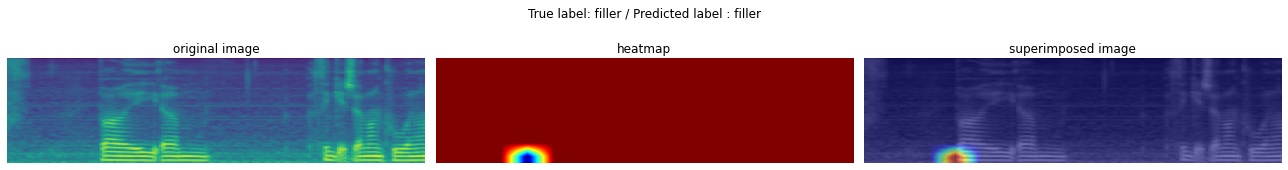

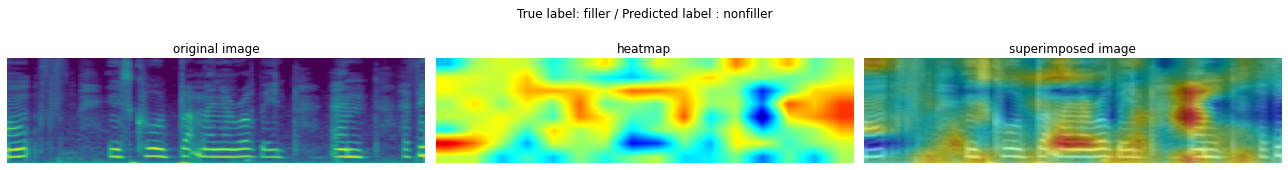

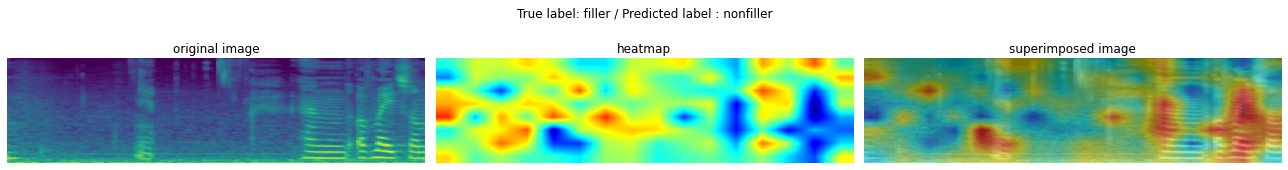

In [50]:
import random

fillers_mel = glob('/content/sashank_Teja_paperwork/Teja_work/teja_data/melspectrogram_data/f/*.png')

#Generate 5 random numbers between 10 and 30
randomlist = random.sample(range(0, len(fillers_mel)), 5)

for i in randomlist:
    lab = [1.0,0.0]
    img = read_img(fillers_mel[i])
    plot(model=model, cam_func=grad_cam, img=img, cls_true=lab)

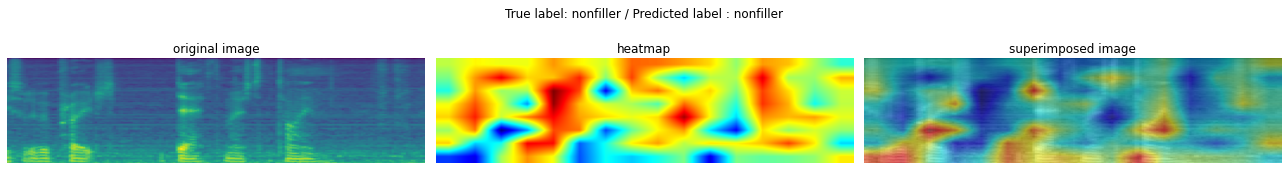

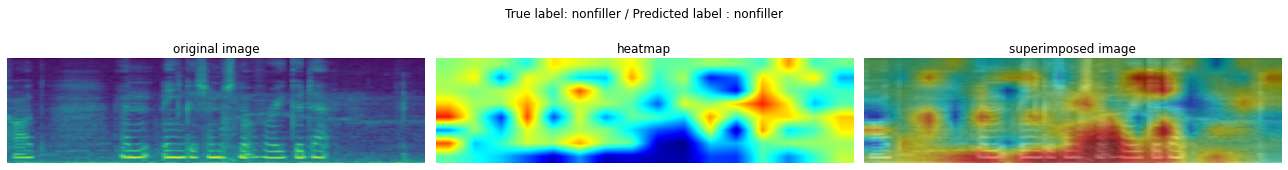

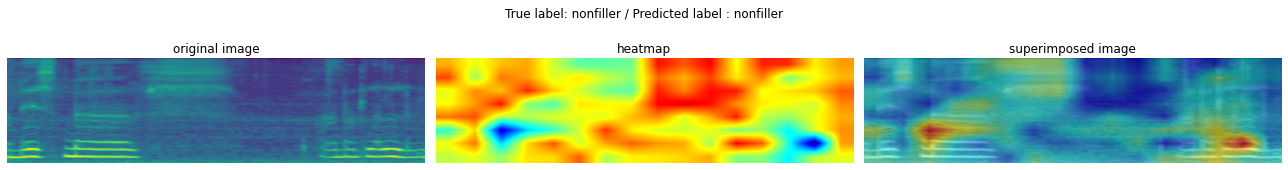

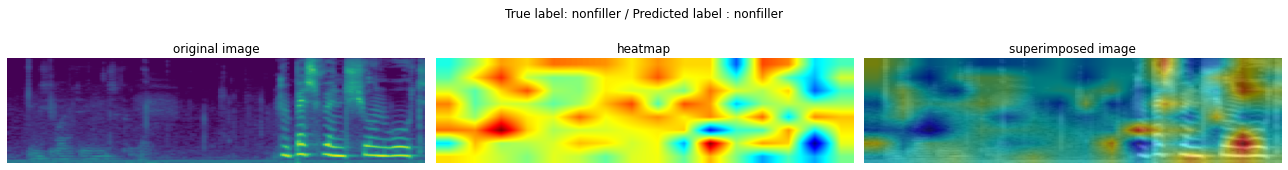

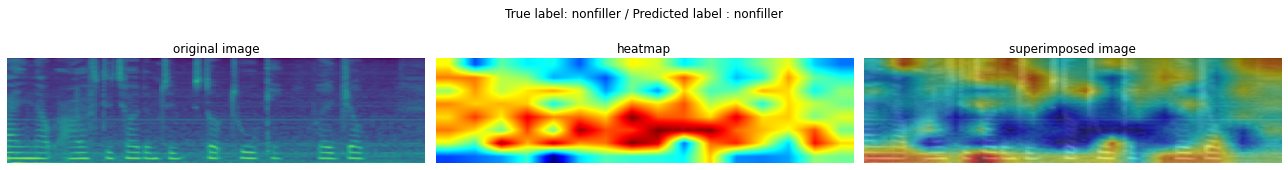

In [51]:
import random

nonfillers_mel = glob('/content/sashank_Teja_paperwork/Teja_work/teja_data/melspectrogram_data/nf/*.png')

#Generate 5 random numbers between 10 and 30
randomlist = random.sample(range(0, len(nonfillers_mel)), 5)

for i in randomlist:
    lab = [0.0,1.0]
    img = read_img(nonfillers_mel[i])
    plot(model=model, cam_func=grad_cam, img=img, cls_true=lab)